In [1]:
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt 
import random 
import math
import cmath
import sympy

# Solution 1.1

In [2]:
def get_cov(f, points1, points2):
    '''
    Return covariance matrix for the sets of points given according to covariance function f.
    params: 
        f: covariance function
        points1: first vector of points
        points2: second vector of points
    '''
    size1 = points1.shape[0]
    size2 = points2.shape[0]
    cov = np.empty((size1, size2)) 
    for i in range(size1):
        for j in range(size2):
            cov[i, j] = f(points1[i], points2[j])
    return cov  

In [3]:
# examples of covariance functions 

def K_Linear(s,t):
    return abs(s-t)

def Sinc(s, t):
    return np.sinc(s-t)

def K_Wiener(s, t):
    return min(s, t)

def K_RBF(s, t):
    return np.exp(-0.5 * abs(s-t)**2)

def K_brownian_bridge(s, t):
    return min(s, t) - s*t

def exponential(s, t):
    return np.exp(-abs(s-t))

def wave(s,t):
    return np.cos(s-t)

# example
a = np.linspace(2, 5, 4)
b = np.linspace(4, 7, 5)
print(f'a: {a}')
print(f'b: {b}')
print(f'get_cov(wave, a, b):\n {get_cov(wave, a, b)}')

# covariance functions buit as Fourier transporms of nice spectral density functions:
# triangular density
def ift_triangle(s, t):  
    if abs(s-t) <= 10e-3:
        return 1 - (s-t)**2/24
    else:
        return 2*(1 - np.cos(s-t))/(s-t)**2/np.sqrt(2*np.pi)

# exponential density     
def ift_exponential(s, t): 
    return np.sqrt(2/np.pi)/((s-t)**2 + 1)

a: [2. 3. 4. 5.]
b: [4.   4.75 5.5  6.25 7.  ]
get_cov(wave, a, b):
 [[-0.41614684 -0.92430238 -0.93645669 -0.44608749  0.28366219]
 [ 0.54030231 -0.17824606 -0.80114362 -0.99412968 -0.65364362]
 [ 1.          0.73168887  0.0707372  -0.62817362 -0.9899925 ]
 [ 0.54030231  0.96891242  0.87758256  0.31532236 -0.41614684]]


In [4]:
# examples of mean functions 
def square(s):
    return s*s

def linear(s):
    return s

# we will mostly use zero mean
def zero(s): 
    return 0

In [5]:
def simulate_GP(mean_function, cov_function, nb_of_samples, number_of_functions, left_border, right_border, X = None, ls = True):
    '''
    Generate and draw discrete realizations of a Gaussian process based on its mean and covariance functions.
    return: 
        ys: vector of realizations
        fig: plot (optional)
    params:
        mean_function: mean function
        cov_function: covariance function
        nb_of_samples: number of sampling points on the x-axis
        number_of_functions: number of realizations to build
        left_border: left border of sampling interval
        right_border: right border of sampling interval
        ls: if True, draw the plot
    '''
    # initialize sampling points on the x-axis
    if np.all(X) == None:
        points = np.linspace(left_border, right_border, nb_of_samples)  
    else:
        points = X
    
    # initialize covariance matrix and mean points
    Σ = get_cov(cov_function, points, points)
    mean_vals = [mean_function(point) for point in points]
    
    # generate random gaissian function
    ys = np.random.multivariate_normal(
                                       mean_vals,
                                       cov=Σ,
                                       size=number_of_functions)
    # draw
    fig = plt.figure(figsize=(12, 6), dpi=80)
    for i in range(number_of_functions):
        if ls: 
            plt.plot(points, ys[i])
            plt.plot(points, np.zeros_like(points), color = 'green')     
    return ys, fig

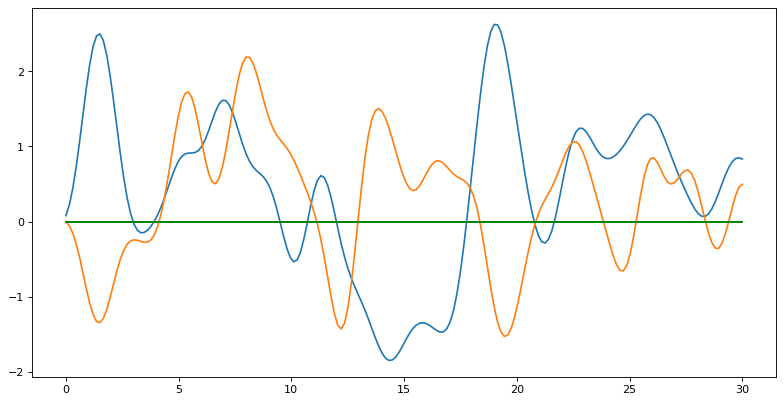

In [6]:
a = simulate_GP(zero, K_RBF, 200, 2, 0, 30)

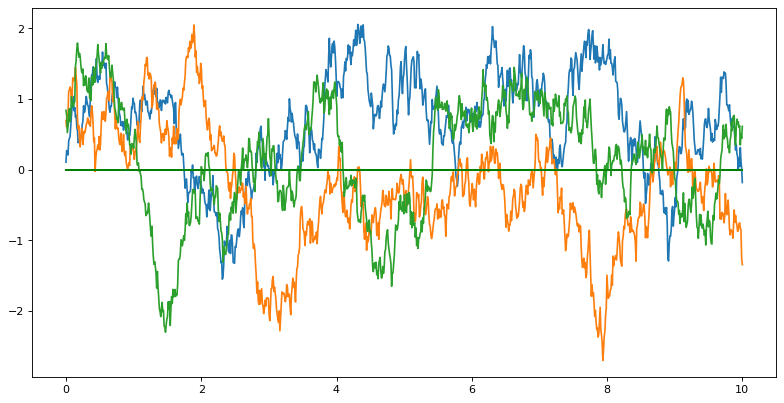

In [7]:
a = simulate_GP(zero, exponential, 1000, 3, 0, 10)

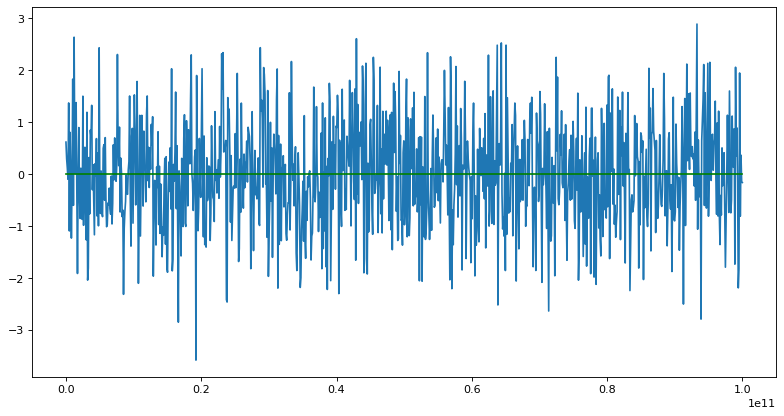

In [8]:
a = simulate_GP(zero, Sinc, 1000, 1, 0, 100000000000)

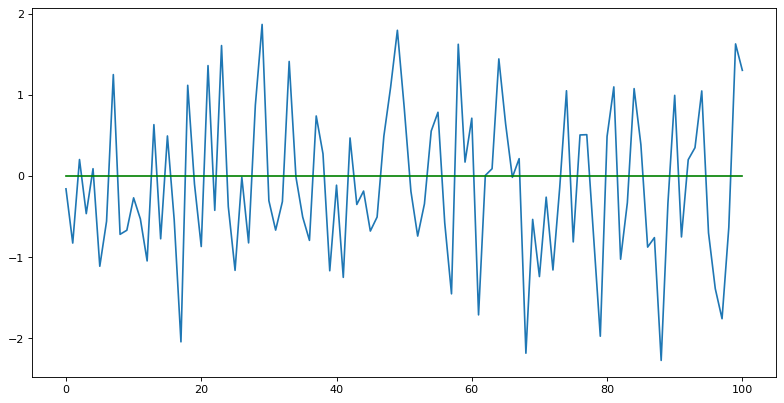

In [9]:
a = simulate_GP(zero, Sinc, 101, 1, 0, 100, ls = True)

The more samples, the bigger time of work. Not depending on a kernel chosen. However, when covariance matrix is small enough (less or equal to 1000x1000), algorythm works fast even on big time intervals.

# Zeros count 
According to Kac-Rice formula, the average number of zeros of the Gaussian process on a unit interval can be calculated by the formula: 
$$\alpha = \frac{1}{\pi}\sqrt{\frac{-r"(0)}{r(0)}},$$
where $r(t)=cov(f(t), f(t)).$

Let us compute r's first and second derivatives as follows:

In [6]:
def prime(f,x):
    e = 10e-8
    return (f(x+e) - f(x-e) )/(2*e)
   
def prime_prime(f, x):
    e = 10e-4
    return ( f(x+e) - 2*f(x) + f(x-e) )/e/e

In [7]:
# example of calculating second derivative
def cube(x):
    return x*x*x

prime_prime(cube, 3)

18.000000000739647

In [8]:
def E(cov_function):
    '''
    return:
        E_zeros: Kac-Rice constant
    params: 
        cov_function: covariation function
    '''    
    r = lambda x: cov_function(0, x) # covariance function 
    
    deriv = -prime_prime(r, 0) # minus second derivative
    alfa = np.sqrt(deriv/(r(0)+10e-8))
    E_zeros = 1/np.pi * alfa # count average amount of zeroes using Kac-Rice formula
        
    return E_zeros    

In [9]:
# comparison function
def cmp(a, b): 
    if a > b:
        return 1
    elif a < b:
        return -1
    else:
        return 0


def intersections(mean_function,
                  cov_function,
                  nb_of_samples,
                  number_of_functions,
                  left_border,
                  right_border,
                  ls = True,
                  y = True):
    '''
    Generate number_of_functions discrete realizations of Gaussian process using solution 1.1
    and count number of zeroes for each iteration.
    return:
        zeros: vector of numbers of zeroes for each realization
        E_zeros: mean number of zeroes obtained from Kac-Rice formula
        Y: realizations generated using solution 1.1 (optional)
    params:
        mean_function: mean function
        cov_function: covariance function
        nb_of_samples: number of sampling points on the x-axis
        number_of_functions: number of realizations to build
        left_border: left border of sampling interval
        right_border: right border of sampling interval
        ls: if True, draw histigram of numbers of zeroes
        y: if True, return Y
    '''
    zeros = np.zeros(number_of_functions) # future numbers of zeroes for all the reali
    Y, _ = simulate_GP(mean_function,
                       cov_function,
                       nb_of_samples,
                       number_of_functions,
                       left_border, right_border, X=None, ls=ls)
    size = Y.shape[1]
    
    # count number of zeroes
    for j in range(number_of_functions): # increment zeroes number when two neigbouring values are of differet signs
        pairs = [(Y[j][i], Y[j][i+1]) for i in range(size - 1)]  # check every pair of neigbouring values
        for (a,b) in pairs:
            if cmp(a, 0) != cmp(b, 0):
                zeros[j] += 1
    
    E_zeros = E(cov_function) * (right_border - left_border) # count mean number of zeroes 
    
    # draw the plot 
    if ls:
        # to see the plot, enable the following string:
        #plt.figure(figsize = (10, 5), dpi=80)
        plt.hist(zeros, edgecolor='white')
        print('E_zeros:',E_zeros)
    if y:
        return zeros, E_zeros, Y
    else:
        return zeros, E_zeros

E_zeros: 57.73500978473921


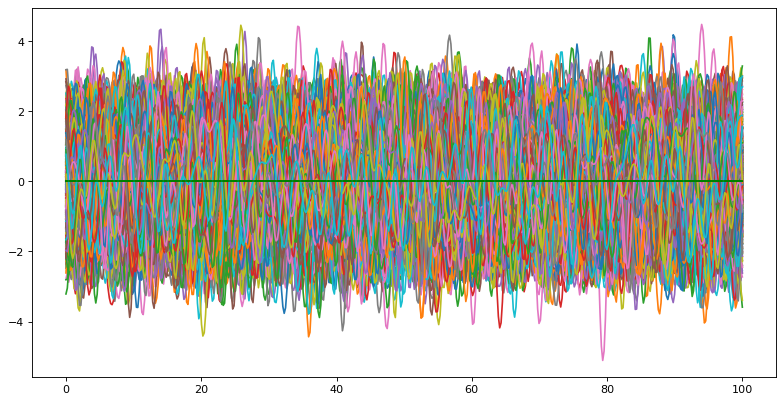

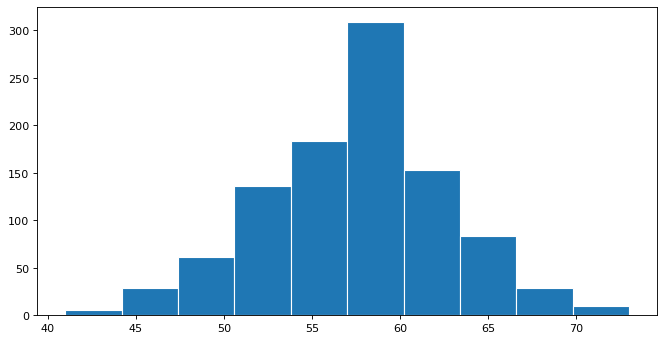

In [20]:
a = intersections(zero, Sinc, 500, 1000, 0, 100)

E_zeros: 17.0


<Figure size 960x480 with 0 Axes>

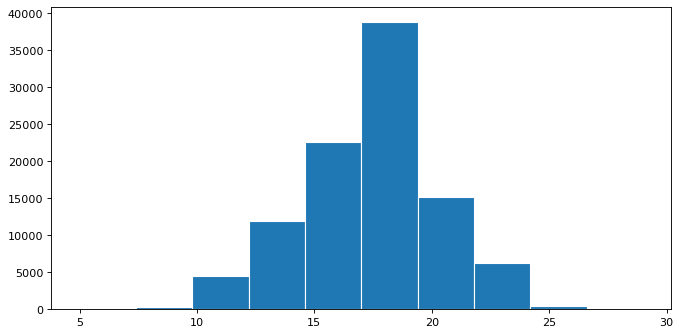

In [14]:
a = intersections(zero, Sinc, 200, 100000, 0, 30, ls=False)

E_zeros: 58.0


<Figure size 960x480 with 0 Axes>

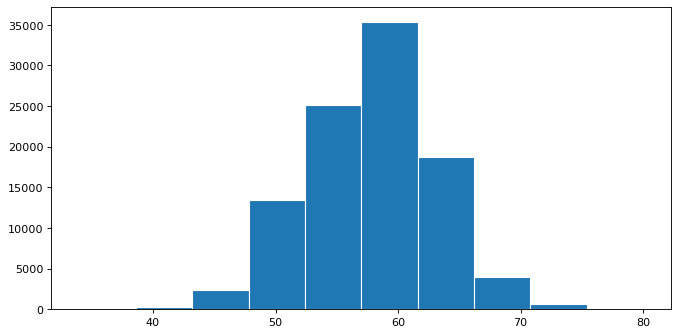

In [16]:
a = intersections(zero, Sinc, 1000, 100000, 0, 100, ls=False)

E_zeros: 577.0


<Figure size 960x480 with 0 Axes>

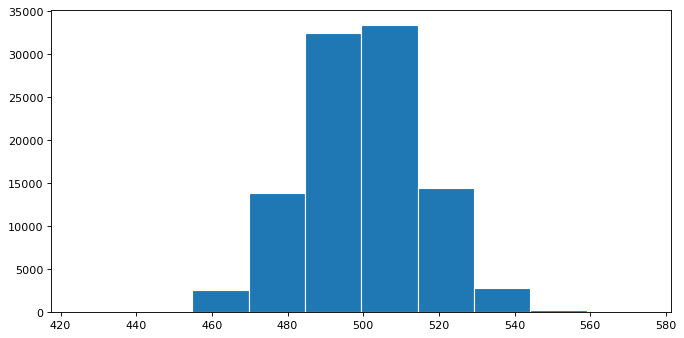

In [17]:
a = intersections(zero, Sinc, 1000, 100000, 0, 1000, ls=False)

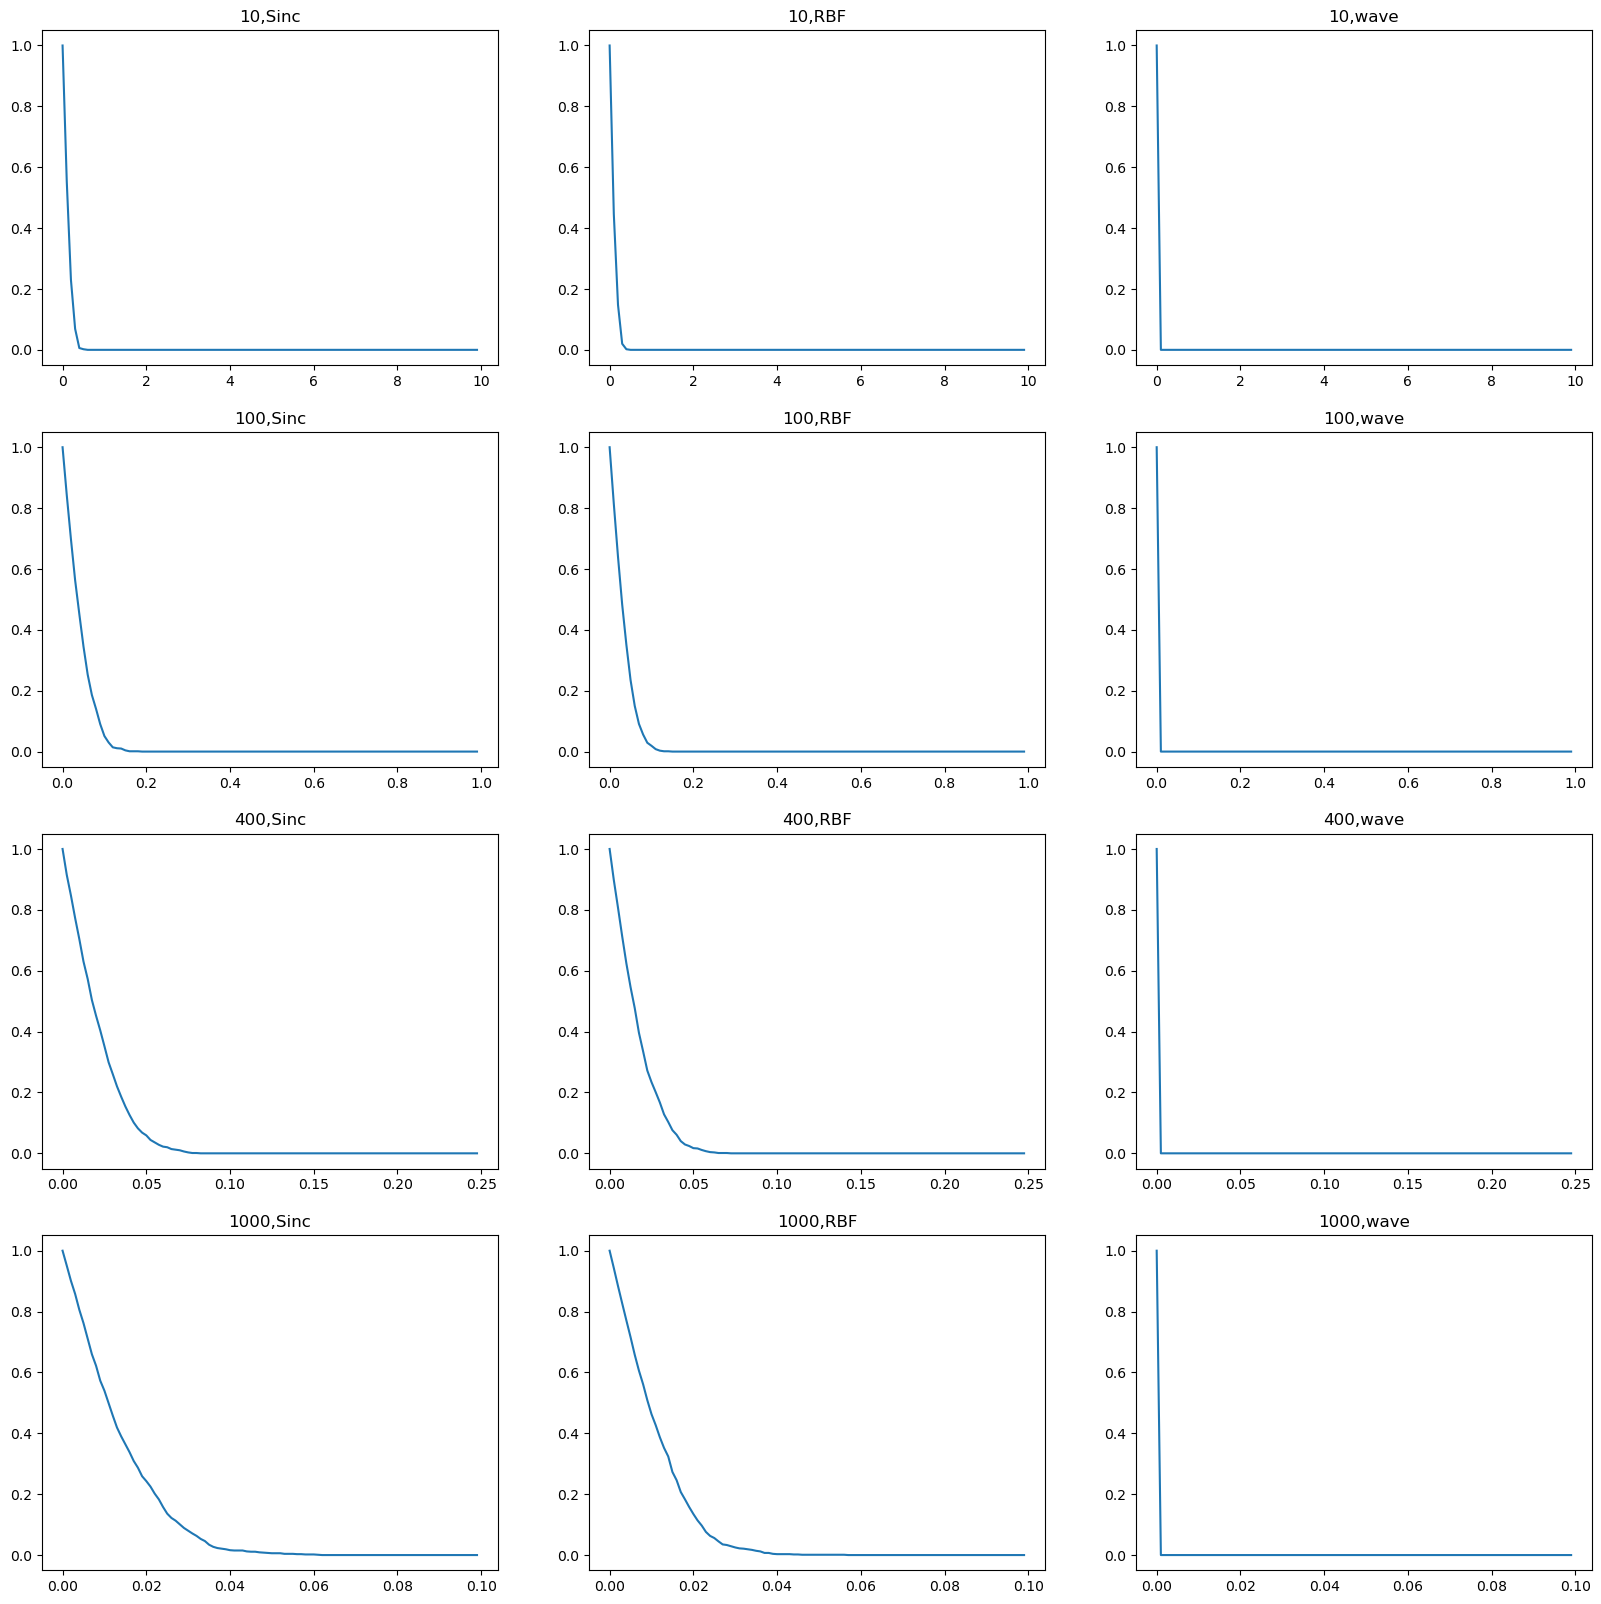

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [22]:
# build plots: P(number-of-zeroes / T > E(T=1) + e) dependance on e. 
# Each row corresponds to some fixed T
# Each column corresponds to some fixed covariance function

T = [10, 100, 400, 1000] # time intervals
kernel = [Sinc, K_RBF, wave] # covariance functions
kernel_names = ["Sinc", "RBF", "wave"] 

fig, axs = plt.subplots(4, 3, figsize=(20, 20))
for i in range(len(T)):
    eps = [n/T[i] for n in range(100)] 
    for j in range(len(kernel)):
        P = np.zeros(len(eps))
        zeros, _ = intersections(zero, kernel[j], T[i]*5, 1000, 0, T[i], ls = False, y = False) 
        for idx,e in enumerate(eps):
            cnt = 0
            for k in range(len(zeros)):
                if abs(zeros[k]/T[i] - E(kernel[j])) > e:
                    P[idx] += 1            
        P = P/1000
        axs[i, j].plot(eps, P)
        axs[i, j].set_title(f'{T[i]},{kernel_names[j]}')

<ipython-input-7-cc1bcf3c7725>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 6), dpi=80)


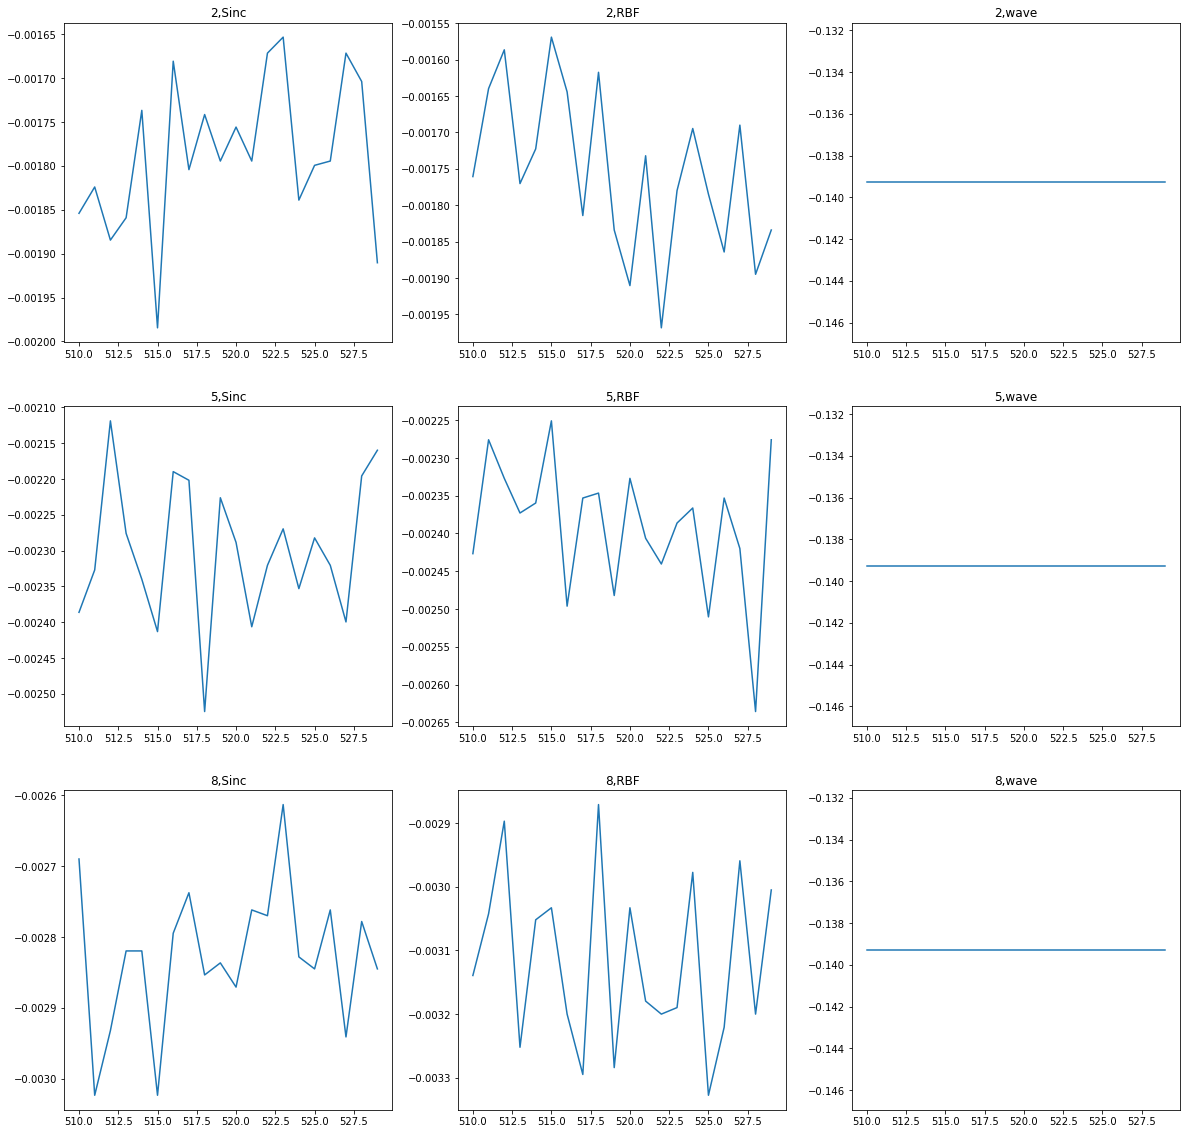

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [49]:
# build plots: P(number-of-zeroes / T > E(T=1) + e) dependance on T. 
# Each row corresponds to some fixed e
# Each column corresponds to some fixed covariance function

plt.close('all')

Eps = [2, 5, 8] # epsilon
kernel = [Sinc, K_RBF, wave] # covariance functions
kernel_names = ["Sinc", "RBF", "wave"]
T = [n for n in range(510, 530)] # time intervals 

fig, axs = plt.subplots(len(Eps), len(kernel), figsize=(20, 20))
for i in range(len(Eps)):
    for j in range(len(kernel)):
        P = np.zeros(len(T))
        for idx, t in enumerate(T):
            zeros, _ = intersections(zero, kernel[j], t*5, 1000, 0, t, ls = False) 
            cnt = 0
            for k in range(len(zeros)):
                if zeros[k]/t - E(kernel[j]) > Eps[i]/t:
                    P[idx] += 1
        P += 10e-30            
        P = np.log(P/1000)
        axs[i, j].plot(T, P/t)
        axs[i, j].set_title(f'{Eps[i]},{kernel_names[j]}')

# Solution 1.2

In [10]:
def Gaussian_Posterior(X1, y1, X2, cov_func):
    '''
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    params: 
        X1: first vector of x-axis samples observed
        y1: values observed in X1
        X2: second vector of x-axis samples observed
        cov_func: covariance function
    return: 
        μ2: posterior mean vector
        Σ2: posterior covariance matrix
    '''
    # Kernel of the observations
    N = X1.shape[0]
    add = np.eye(N)
    Σ11 = get_cov(cov_func, X1, X1) + add*10e-12
    # Kernel of observations vs to-predict
    Σ12 = get_cov(cov_func, X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = get_cov(cov_func, X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [11]:
def random_posterior(mean_function, cov_function, nb_of_samples, 
                     left_border,
                     right_border,
                     iterations,
                     ls = True,
                    ):
    '''
    Create number_of_samples Gaussian values on interval
    [left_border, right_border]
    according to prior distribution of the previous
    values. The first set of values is generated by means of Simulate_GP. 
    Each iteration the algoritm repeats itself with the prevoius iteration result set as prior.
    return: 
        fig: plot (optional)
        y: vector, discrete realization of the Gaussian process
    params:
        mean_function: mean function
        cov_function: covariance function
        number_of_samples: number of sampling points on the x-axis
        left_border: left border of sampling interval
        right_border: right border of sampling interval
        iterations: numbe rof iterations to perform
        ls: if True, draw histigram of numbers of zeroes 
    '''
    
    Graph = [] # future array of pairs of abscissa points and values (x,y). We will use them to build a graph.
    X1 = []
    for i in range(nb_of_samples):
        X1.append(np.random.uniform(left_border, right_border)) # first iteration. take nb_of_samples points from x-axis
    y1, fig = simulate_GP(mean_function, # generate y1 with a given covariance matrix
                          cov_function,
                          nb_of_samples,
                          1,
                          left_border,
                          right_border,
                          X = np.array(X1),
                          ls = False)
    y1 = np.squeeze(y1) # we usually ask simulate_GP to build many functions in one call, so y1 has an extra dimension
    for k in range(nb_of_samples):
        Graph.append((X1[k], y1[k]))
    
    for iter in range(iterations):
        X2 = [] 
        for i in range(nb_of_samples): # each iteration randomly uniformly choose x-axis samples
            X2.append(np.random.uniform(left_border, right_border)) 
        μ2, Σ2 = Gaussian_Posterior(np.array(X1), y1, np.array(X2), cov_function) # recalculate the distribution
        y2 = np.random.multivariate_normal(μ2, cov=Σ2) # generate y2 out of the renewed distribution 
        for k in range(nb_of_samples): 
            Graph.append((X2[k], y2[k]))
        X1 = X2
        y1 = y2
        
    # draw the plot    
    Graph = sorted(Graph, key = lambda x: x[0])
    X = [g[0] for g in Graph]
    y = [g[1] for g in Graph]
    if ls:       
        plt.plot(X, y, figure = fig)
        plt.plot(X, np.zeros_like(X), color = 'green')     
        plt.show() 
    return y, fig     

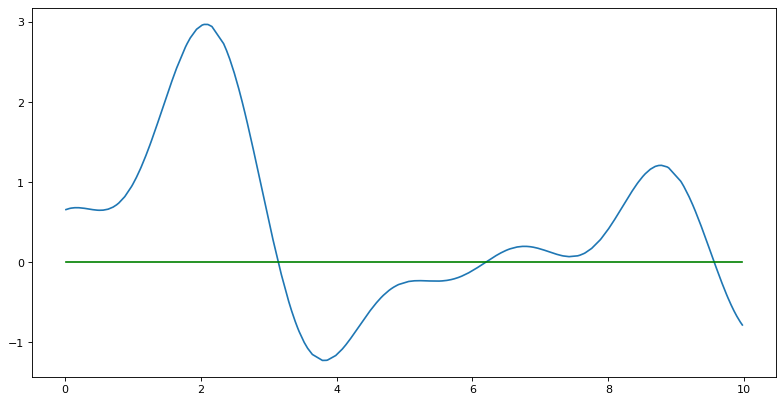

In [34]:
a = random_posterior(zero, Sinc, 140, 0, 10, 1, ls = True)

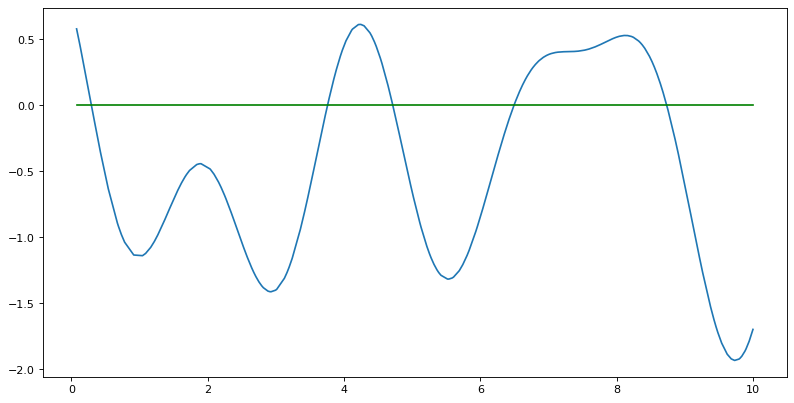

In [47]:
a = random_posterior(zero, Sinc, 50, 0, 10, 5, ls = True)

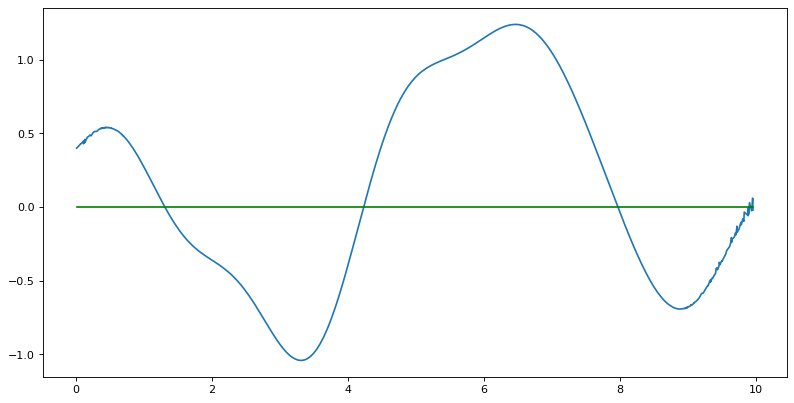

In [46]:
a = random_posterior(zero, Sinc, 30, 0, 10, 30, ls = True)

Increasing number of iterations leads to jumps.

# Solution 1.3
The same as the previus one, but with another sampling. Instead of sampling x-axis points randomly every new iteration, let us use semisums of all the neigbouring points sampled earlier.

In [12]:
def binary_posterior(mean_function, cov_function,
                     nb_of_samples, 
                     left_border,
                     right_border,
                     iterations,
                     ls = True,):
    '''
    Create number_of_samples Gaussian values on interval
    [left_border, right_border]
    according to prior distribution of the previous
    values. The first set of values is generated by means of Simulate_GP. 
    Each iteration the algoritm repeats itself with the prevoius iteration result set as prior.
    return: 
        y: vector, discrete realization of the Gaussian process
        fig: plot (optional)
    params:
        mean_function: mean function
        cov_function: covariance function
        number_of_samples: number of sampling points on the x-axis
        left_border: left border of sampling interval
        right_border: right border of sampling interval
        iterations: numbe rof iterations to perform
        ls: if True, draw histigram of numbers of zeroes 
    '''
    Graph = [] # future array of pairs of abscissa points and values (x,y). We will use them to build a graph.

    X1 = np.linspace(left_border, right_border, nb_of_samples) # first iteration. take nb_of_samples x-axis points
    y1, fig = simulate_GP(mean_function, # 
                          cov_function,
                          nb_of_samples,
                          1,
                          left_border,
                          right_border,
                          ls = False)
    y1 = np.squeeze(y1) # we can ask simulate_GP to build many functions in one call, so y1 has an extra dimension.
    for k in range(nb_of_samples):
        Graph.append((X1[k], y1[k]))
    
    all_x = list(X1)
    for iter in range(iterations):
        l = len(all_x)
        X2 = []
        tmp = []
        for j in range(l-1):
            X2.append((all_x[j+1] + all_x[j])/2)
            tmp.append(all_x[j])
            tmp.append((all_x[j+1] + all_x[j])/2)
        tmp.append(all_x[-1])
        
        μ2, Σ2 = Gaussian_Posterior(np.array(X1), y1, np.array(X2), cov_function) # recalculate the distribution
        y2 = np.random.multivariate_normal(μ2, cov=Σ2) # generate y out of reneed distribution
        for k in range(len(X2)): 
            Graph.append((X2[k], y2[k]))
        X1 = X2
        y1 = y2
        all_x = tmp
    Graph = sorted(Graph, key = lambda x: x[0])
    X = [g[0] for g in Graph]
    y = [g[1] for g in Graph]
    if ls:       
        plt.plot(X, y, figure = fig)
        plt.plot(X, np.zeros_like(X), color = 'green')     
        plt.show() 
    return y, fig     

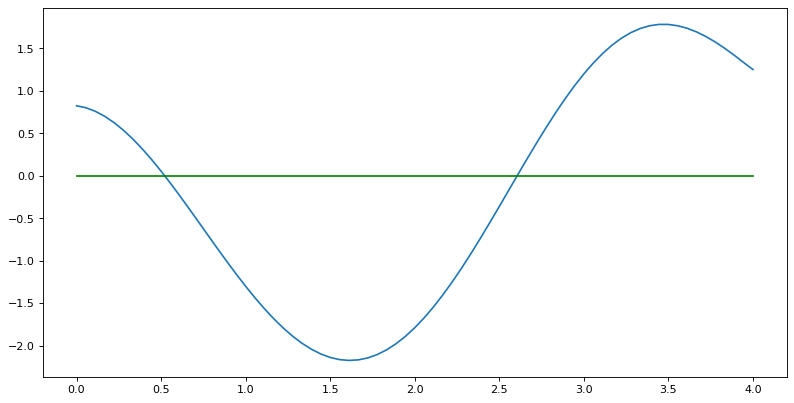

In [63]:
a = binary_posterior(zero, Sinc, 10, 0, 4, 3, ls = True)

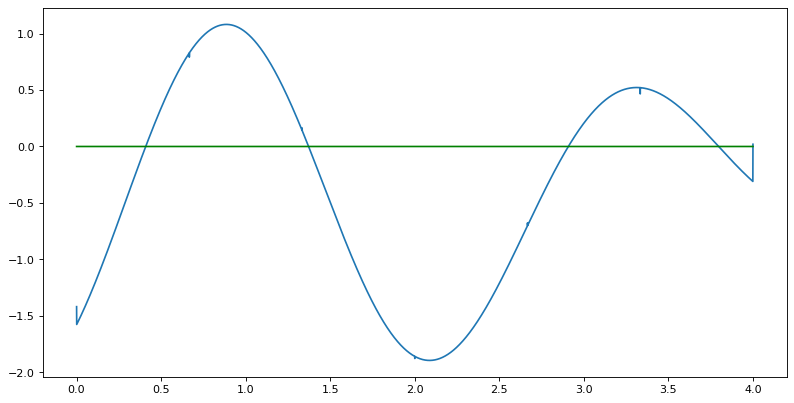

In [55]:
a = binary_posterior(zero, Sinc, 7, 0, 4, 10, ls = True)

We also face these jumps using algorithm 1.2.

# Solution 1.4
One more version of the algorithm 1.1, but here we generate the first set of x-axis samples as usual and then shift every point to the right, on the same inteerval each iteration. Also generate many realizations at once if necessary.

In [13]:
def Posterior3(mean_function, cov_function, nb_of_samples, number_of_functions, left_border, right_border, iterations, ls = True):
    '''
    Create number_of_samples Gaussian values on interval
    [left_border, right_border]
    according to prior distribution of the previous
    values. The first set of values is generated by means of Simulate_GP. 
    Each iteration the algoritm repeats itself with the prevoius iteration result set as prior.
    return: 
        y: vector of discrete realizations of the Gaussian process
        fig: plot (optional)
    params:
        mean_function: mean function
        cov_function: covariance function
        number_of_samples: number of sampling points on the x-axis
        number_of_functions: number of realizations to build
        left_border: left border of sampling interval
        right_border: right border of sampling interval
        iterations: numbe rof iterations to perform
        ls: if True, draw histigram of numbers of zeroes 
    '''
    
    len_interval = (right_border - left_border) / (iterations+1)
    delta = len_interval/(nb_of_samples - 1)

    final_y = np.zeros((number_of_functions, (iterations+1)*nb_of_samples))
    # create initial values using solution 1
    X1 = np.linspace(left_border, left_border+len_interval, nb_of_samples)
    y1, fig = simulate_GP(mean_function, 
                          cov_function,
                          nb_of_samples,
                          number_of_functions,
                          left_border,
                          left_border+len_interval,
                          ls = False)
    
    for func in range(number_of_functions): 
        y = np.zeros((iterations+1, nb_of_samples))
        X = np.zeros((iterations+1, nb_of_samples))
        y[0,:] = y1[func]
        X[0,:] = X1
        for it in range(1, iterations+1):
            X2 = np.linspace(left_border + len_interval*it, left_border + len_interval*(it+1), nb_of_samples)
            #compute posterior distribution 
            μ2, Σ2 = Gaussian_Posterior(X[it-1,:], y[it-1,:], X2, cov_function)
            #generate new samples
            y[it, :] = np.random.multivariate_normal(μ2, cov=Σ2)
            X[it, :] = X2
            
        X = np.reshape(X,((iterations+1)*nb_of_samples,))  
        final_y[func] = np.reshape(y,((iterations+1)*nb_of_samples,))
        if ls:       
            plt.plot(X, final_y[func], figure = fig)
            plt.plot(X, np.zeros_like(X), color = 'green')     
         
    if ls:
        plt.show() 
    return final_y, fig  

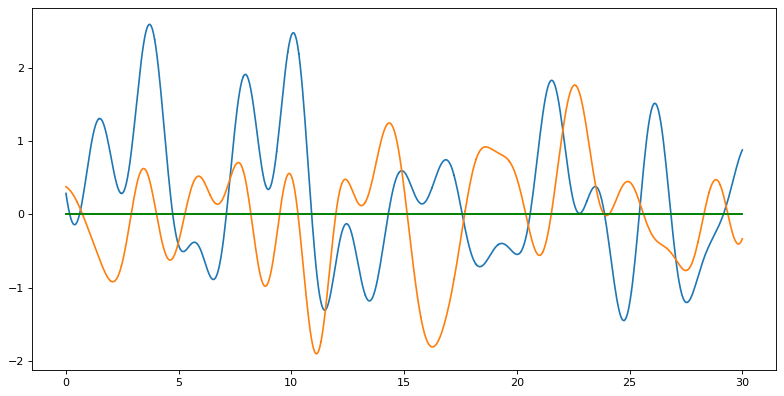

In [42]:
a = Posterior3(zero, Sinc, 10, 2, 0, 30, 60)

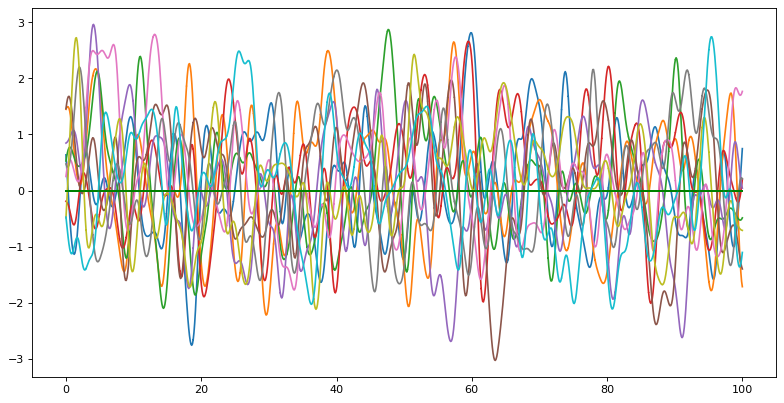

In [66]:
a = Posterior3(zero, K_RBF, 10, 10, 0, 100, 100)

The folowing function repeats the content of the function "intersections", but for the solution 1.4:

In [14]:
def post_intersections(mean_function, cov_function, nb_of_samples, number_of_functions, left_border, right_border, iterations, ls = True, y = False):
    '''
    Generate number_of_functions discrete realizations of Gaussian process using solution 1.4
    and count number of zeroes for each iteration.
    return:
        zeros: vector of numbers of zeroes for each realization
        E_zeros: mean number of zeroes obtained from Kac-Rice formula
        Y: realizations generated using solution 1.1 (optional)
    params:
        mean_function: mean function
        cov_function: covariance function
        nb_of_samples: number of sampling points on the x-axis
        number_of_functions: number of realizations to build
        left_border: left border of sampling interval
        right_border: right border of sampling interval
        ls: if True, draw histigram of numbers of zeroes
        y: if True, return Y
    '''
    zeros = np.zeros(number_of_functions) # future amount of zeros for all functions  
    Y, _ = Posterior3(mean_function,
                      cov_function,
                      nb_of_samples,
                      number_of_functions,
                      left_border,
                      right_border,
                      iterations,
                      ls)
    size = Y.shape[1]
    
    # count amount of zeros
    for j in range(number_of_functions): # if two neighbouring values are of different signs, then there's a zero between them
        pairs = [(Y[j][i], Y[j][i+1]) for i in range(size - 1)]  # check every pair of neighbouring values 
        for (a,b) in pairs:
            if cmp(a, 0) != cmp(b, 0): # compare two values
                zeros[j] += 1
    
    E_zeros = E(cov_function) * (right_border - left_border) # count average amount of zeroes using Kac-Rice formula

    if ls: 
        plt.figure(figsize = (10, 5), dpi=80)
        plt.hist(zeros, edgecolor='white')
        print('E_zeros:',E_zeros)
    if y: 
        return zeros, E_zeros, Y
    else:
        return zeros, E_zeros

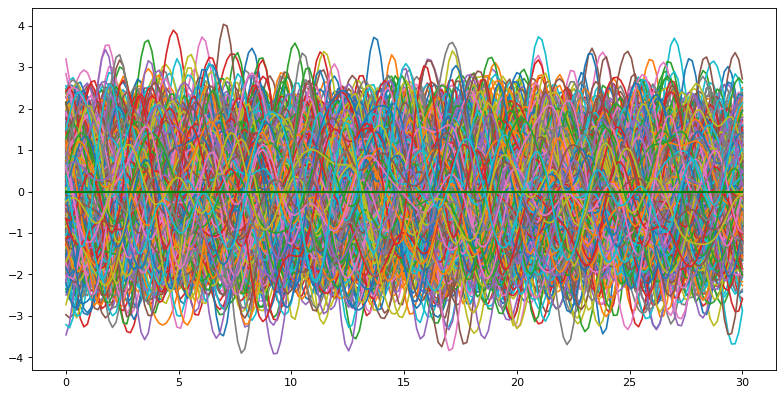

E_zeros: 17.0


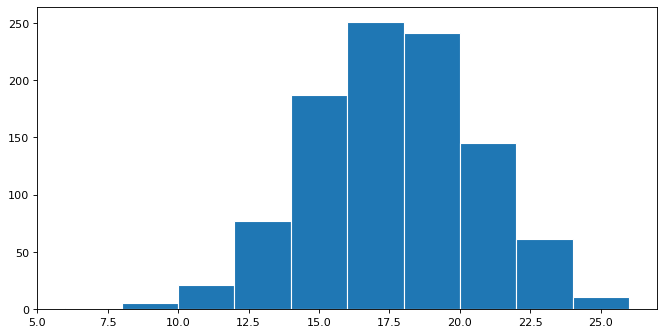

In [22]:
a = post_intersections(zero, Sinc, 10, 1000, 0, 30, 20, ls = True)

In [15]:
def draw_over(kernel, Eps = [0.01, 0.05], T = [50, 100], functions = 200, sup=0.15):
    '''
    Draw real spectral density and power spectrum gained from realizations with overcrowding
    for various epsilon and time intervals.
    params: 
        kernel: covariance function
        Eps: array of epsilon
        T: array of Ts
        functions: number of realizations to generate
        sup: sdraw plots on interval [-sup, sup]    
    '''
    r = lambda x: kernel(0, x)

    fig, axs = plt.subplots(len(Eps), len(T), figsize=(15, 15))

    for i, e in enumerate(Eps):
        for j, t in enumerate(T): 
            # Y -- array of 200 functions, zeros -- array of numbers of zeroes, E_zeros -- average number of zeroes
                                                  # mean, kernel, points, functions, left, right, iterations
            zeros, E_zeros, Y = post_intersections(zero, kernel, 40, functions, 0, t, t//4, ls = False, y = True) 
            overcrowding = np.zeros(Y.shape[1])
            Q = np.fft.fft(overcrowding) # future under_density
            Q = np.array([np.real(q) for q in Q])
            
            size = Q.shape[0]
            N = [i/size for i in range(-size//2, size//2)]
            count = 0
            
            # choose realizations with overcrowding:
            for z in range(len(zeros)):
                if E_zeros - zeros[z] < -e*t:
                    # summarize power spectrums foe all realizations with overcrowding
                    Q0 =  np.fft.fft(Y[z])
                    Q0 = np.array([np.abs(q)**2 for q in Q0])
                    Q0 /= size
                    Q += Q0
                    count += 1
            
            # compute average power spectrum 
            Q /= count + 1e-30
            Q *= t/size/np.sqrt(2*np.pi)
            Q = np.hstack((Q[size//2:], Q[:size//2]))
            over_density = Q
            
            #compute real density
            X = np.linspace(-t/2, t/2, size+1)[:-1]
            k = [r(x) for x in X]  # kernel time points
            true_density = np.fft.fft(k)
            true_density = [abs(np.real(x)) for x in true_density]
            true_density = np.hstack((true_density[size//2:], true_density[:size//2]))
            true_density *= t/size/np.sqrt(2*np.pi)
            
            # draw plot  
            axs[i, j].plot(N, over_density)
            axs[i, j].plot(N, true_density)
            axs[i, j].set_xlim(-sup, sup)
            axs[i, j].set_title(f'Eps = {e},T = {t}')


In [22]:
def draw_under(kernel, Eps = [0.01, 0.05], T = [50, 100], functions = 200, sup=0.15):
    '''
    Draw real spectral density and power spectrum gained from realizations with undercrowding
    for various epsilon and time intervals.
    params: 
        kernel: covariance function
        Eps: array of epsilon
        T: array of Ts
        functions: number of realizations to generate
        sup: sdraw plots on interval [-sup, sup]    
    '''
    r = lambda x: kernel(0, x)

    fig, axs = plt.subplots(len(Eps), len(T), figsize=(15, 15))

    for i, e in enumerate(Eps):
        for j, t in enumerate(T): 
            # Y -- array of 200 functions, zeros -- array of numbers of zeroes, E_zeros -- average number of zeroes
                                                  # mean, kernel, points, functions, left, right, iterations
            zeros, E_zeros, Y = post_intersections(zero, kernel, 40, functions, 0, t, t//4, ls = False, y = True) 
            undercrowding = np.zeros(Y.shape[1])
            Q = np.fft.fft(undercrowding) # future under_density
            Q = np.array([np.real(q) for q in Q])
            
            size = Q.shape[0]
            N = [i/size for i in range(-size//2, size//2)]
            count = 0

            for z in range(len(zeros)):
                if E_zeros - zeros[z] > e*t:
                    Q0 =  np.fft.fft(Y[z])
                    Q0 = np.array([np.abs(q)**2 for q in Q0])
                    Q0 /= size
                    Q += Q0
                    count += 1
                    
            Q /= count + 1e-30
            Q *= t/size/np.sqrt(2*np.pi)
            Q = np.hstack((Q[size//2:], Q[:size//2]))
            under_density = Q

            X = np.linspace(-t/2, t/2, size+1)[:-1]
            k = [r(x) for x in X]                  # kernel time points
            true_density = np.fft.fft(k)
            true_density = [abs(np.real(x)) for x in true_density]
            true_density = np.hstack((true_density[size//2:], true_density[:size//2]))
            true_density *= t/size/np.sqrt(2*np.pi)

            axs[i, j].plot(N, under_density)
            axs[i, j].plot(N, true_density)
            axs[i, j].set_xlim(-sup, sup)
            axs[i, j].set_title(f'Eps = {e},T = {t}')


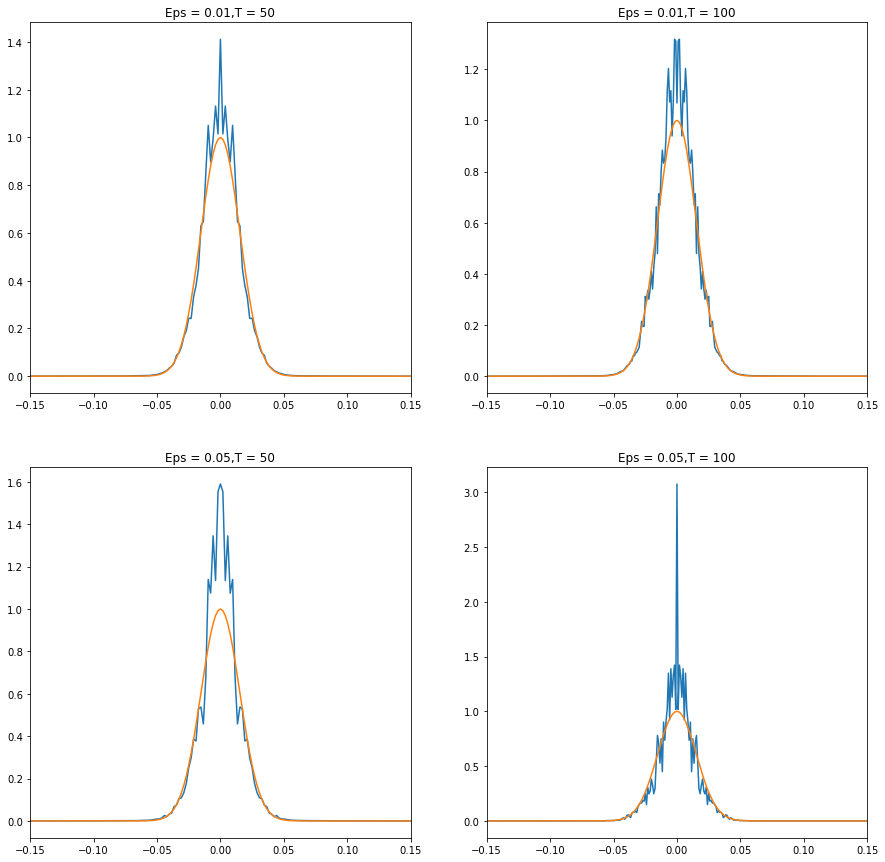

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [77]:
draw_under(K_RBF)

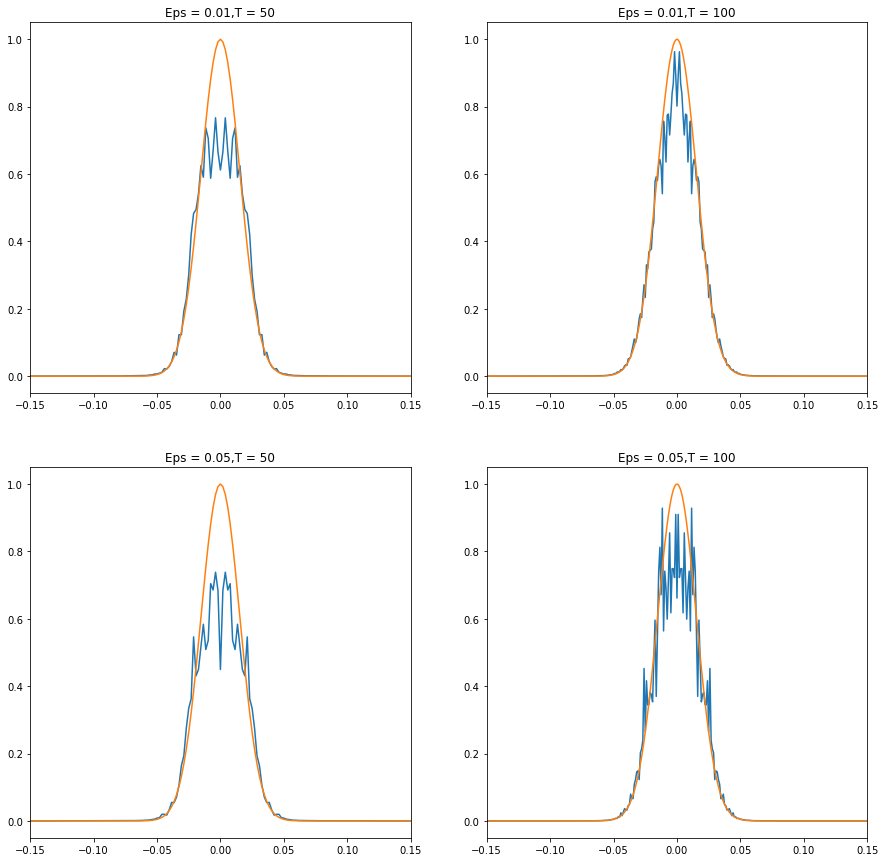

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [82]:
draw_over(K_RBF)

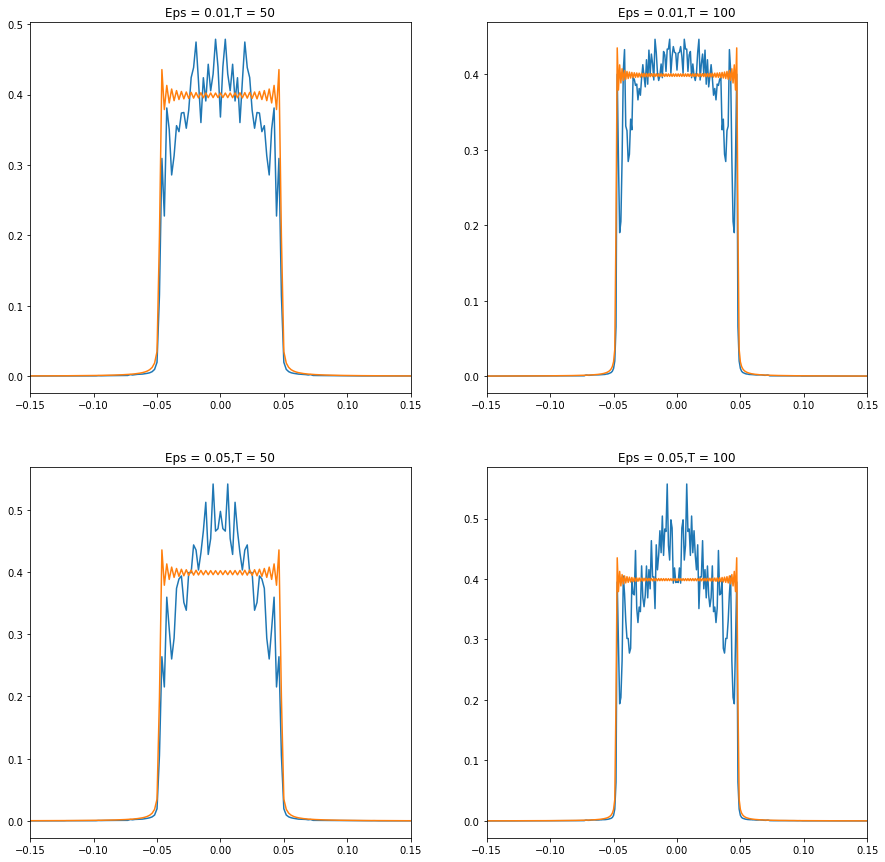

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [83]:
draw_under(Sinc, functions = 1000)

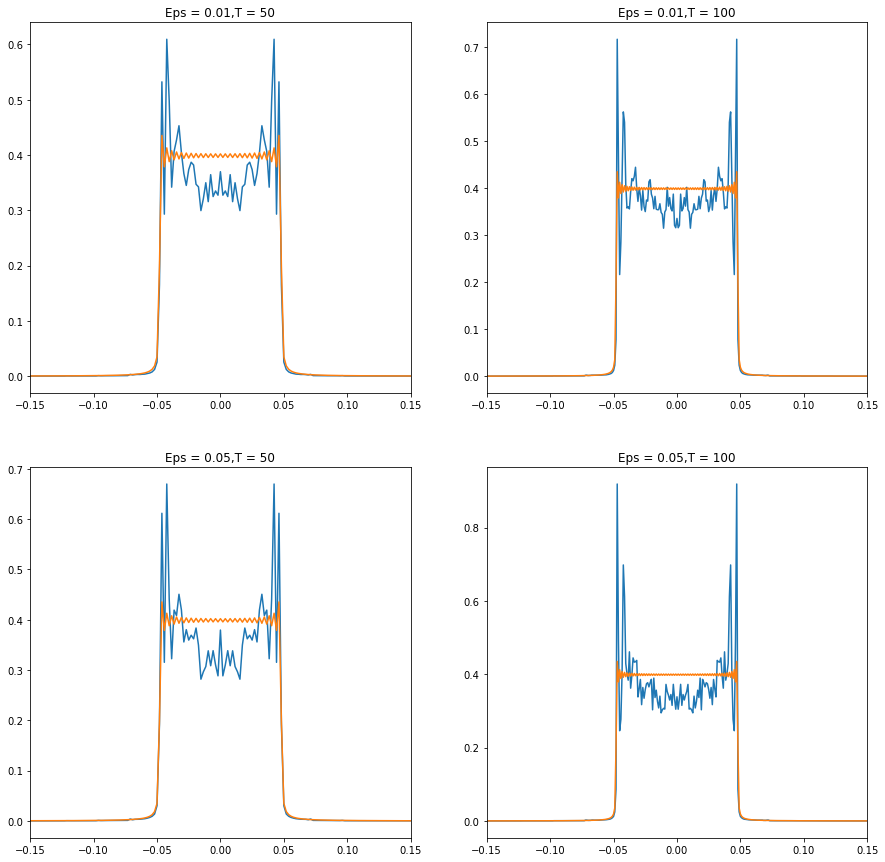

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [84]:
draw_over(Sinc, functions = 1000)

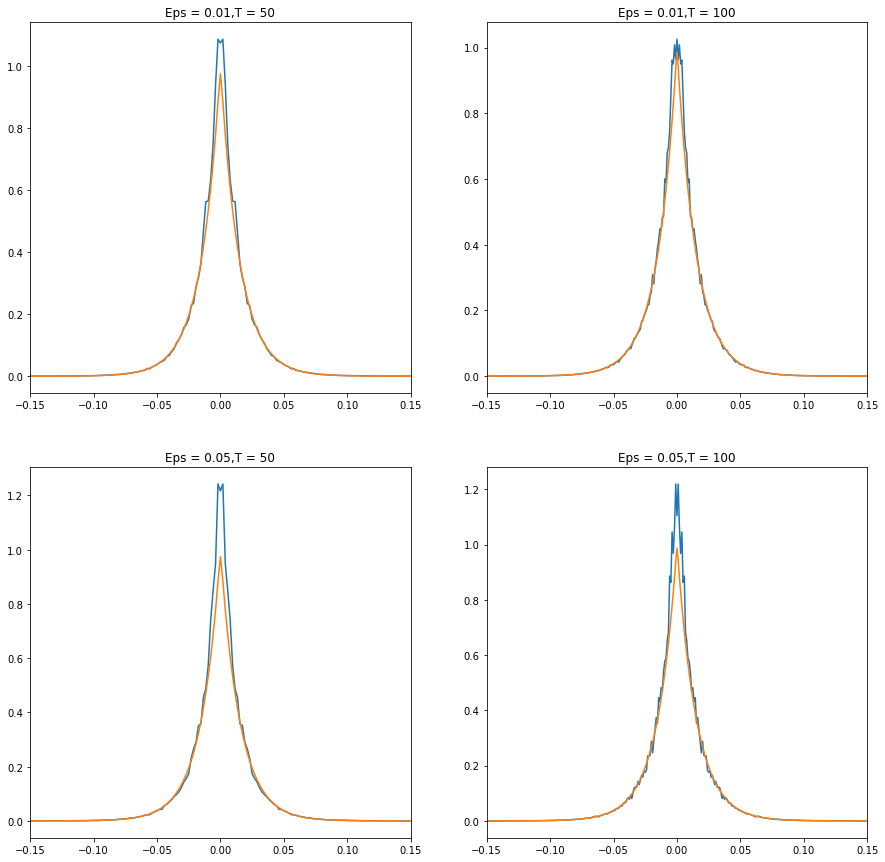

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [85]:
draw_under(ift_exponential, functions = 1000)

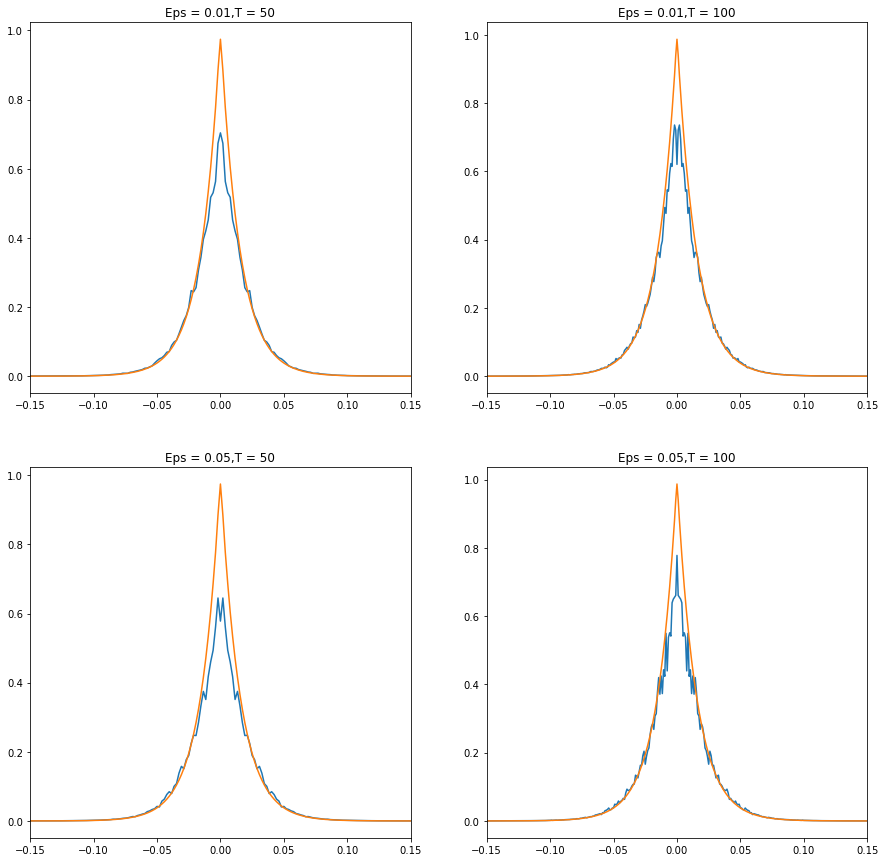

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [86]:
draw_over(ift_exponential, functions = 1000)

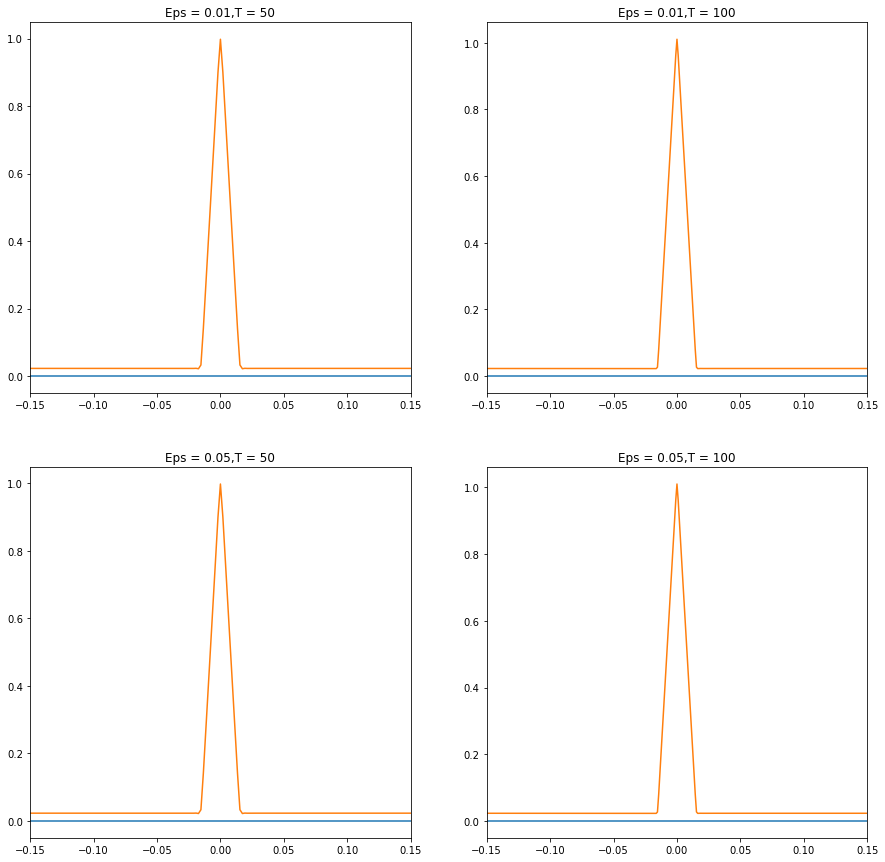

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [26]:
draw_under(ift_triangle, functions = 5000)

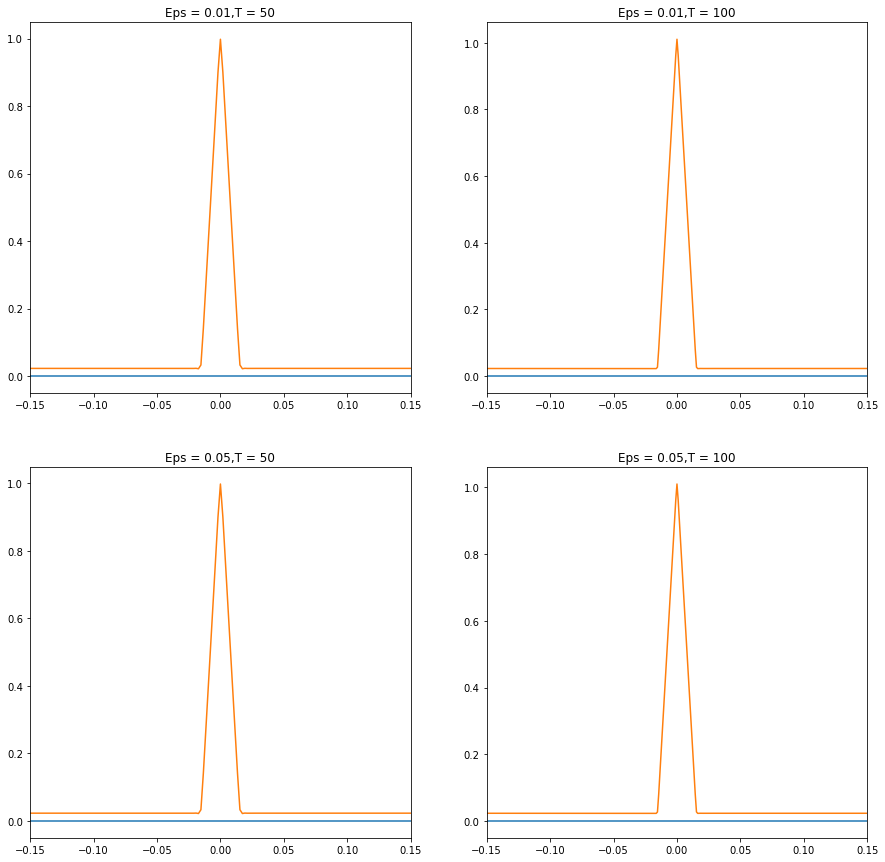

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [23]:
draw_under(ift_triangle, functions = 100)